<a href="https://colab.research.google.com/github/andremartins7/DataHackersSurvey2019/blob/master/tft_data_h_m1_challenge_final_andre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desafio do kaggle**
Data H | M1 Challenge
Predict the weekly sales of retail (Final Stage)
https://www.kaggle.com/c/data-h-m1-challenge-final/leaderboard

In [ ]:
!pip install pytorch_forecasting
!pip install datetime

In [ ]:
# Importação das biliotecas iniciais

import numpy as np
import pandas as pd
from numpy.lib.arraysetops import isin
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

plt.style.use('fivethirtyeight')

import os
import copy
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

from copy import deepcopy
from functools import lru_cache
import inspect
from typing import Callable, Union, Dict, List, Tuple, Any, Iterable

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, TransformerMixin

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import torch.nn as nn

from torch.nn.utils import rnn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler
from torch import ones
from torch.distributions import Binomial, Beta
import torch.nn.functional as F

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import (
    EncoderNormalizer,
    GroupNormalizer,
    MultiNormalizer,
    NaNLabelEncoder,
    TorchNormalizer,
)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Carregando os dados no kaggle
#sales = pd.read_csv('/kaggle/input/data-h-m1-challenge-final/sales.csv')
#item = pd.read_csv('/kaggle/input/data-h-m1-challenge-final/meta-item.csv')
#store = pd.read_csv('/kaggle/input/data-h-m1-challenge-final/meta-store.csv')
#submission = pd.read_csv('/kaggle/input/data-h-m1-challenge-final/submission_sample.csv')

In [ ]:
# Carregando os dados no colab
sales = pd.read_csv('sales.csv')
item = pd.read_csv('meta-item.csv')
store = pd.read_csv('meta-store.csv')
submission = pd.read_csv('submission_sample.csv')

In [ ]:
ds = pd.date_range(start= '2017-08-01', end='2021-09-26', freq='W')
pd.DataFrame (ds, columns = ['DATE'])
ds = ds.to_frame().reset_index()
ds.columns = ['0', 'DATE']

In [ ]:
ds.drop(['0'], axis=1)

,DATE
0,2017-08-06
1,2017-08-13
2,2017-08-20
3,2017-08-27
4,2017-09-03
...,...
212,2021-08-29
213,2021-09-05
214,2021-09-12
215,2021-09-19


In [ ]:
sales['DATE'] = pd.to_datetime(sales['DATE'])
sales = pd.merge(ds, sales, how='outer', on='DATE')
sales.head()

,0,DATE,S100,I100,C100,C101,QTT
0,2017-08-06,2017-08-06,0.0,0.0,12.0,76.0,1.0
1,2017-08-06,2017-08-06,0.0,0.0,12.0,256.0,2.0
2,2017-08-06,2017-08-06,0.0,0.0,14.0,256.0,1.0
3,2017-08-06,2017-08-06,0.0,1.0,13.0,140.0,1.0
4,2017-08-06,2017-08-06,0.0,2.0,13.0,15.0,1.0


In [ ]:
sales.drop(['0'], axis=1)
sales.head()

,0,DATE,S100,I100,C100,C101,QTT
0,2017-08-06,2017-08-06,0.0,0.0,12.0,76.0,1.0
1,2017-08-06,2017-08-06,0.0,0.0,12.0,256.0,2.0
2,2017-08-06,2017-08-06,0.0,0.0,14.0,256.0,1.0
3,2017-08-06,2017-08-06,0.0,1.0,13.0,140.0,1.0
4,2017-08-06,2017-08-06,0.0,2.0,13.0,15.0,1.0


In [ ]:
# Função para analisa o dataset
def load_info(data):
  print('\nThe shape of the dataset is:', data.shape)
  print('\nThe headof the dataset is:\n', data.head(5))
  print('\nThe column types are:\n', data.dtypes)  
  print('\nThe Describing of dataset is:\n',data.describe())
  print('\nThere are null values?\n', data.isnull().sum())

In [ ]:
# análise de sales

load_info(sales)


The shape of the dataset is: (620659, 7)

The headof the dataset is:
            0       DATE  S100  I100  C100   C101  QTT
0 2017-08-06 2017-08-06   0.0   0.0  12.0   76.0  1.0
1 2017-08-06 2017-08-06   0.0   0.0  12.0  256.0  2.0
2 2017-08-06 2017-08-06   0.0   0.0  14.0  256.0  1.0
3 2017-08-06 2017-08-06   0.0   1.0  13.0  140.0  1.0
4 2017-08-06 2017-08-06   0.0   2.0  13.0   15.0  1.0

The column types are:
 0       datetime64[ns]
DATE    datetime64[ns]
S100           float64
I100           float64
C100           float64
C101           float64
QTT            float64
dtype: object

The Describing of dataset is:
                 S100           I100           C100           C101  \
count  620462.000000  620462.000000  620462.000000  620462.000000   
mean       14.819017      45.145579      13.554774     231.306892   
std         8.896358      27.365475       2.248594     114.833161   
min         0.000000       0.000000       0.000000       0.000000   
25%         7.000000      20.

In [ ]:
# Merge dos datasets item, stores

teste = pd.merge(item,sales, how = 'inner', on = 'I100')
sales = pd.merge(store,teste, how = 'inner', on = 'S100')
sales.head()

,S100,S101,S102,S103,I100,I101,I102,I103,0,DATE,C100,C101,QTT
0,0,1,17,10,0,2,1,1,2017-08-06,2017-08-06,12.0,76.0,1.0
1,0,1,17,10,0,2,1,1,2017-08-06,2017-08-06,12.0,256.0,2.0
2,0,1,17,10,0,2,1,1,2017-08-06,2017-08-06,14.0,256.0,1.0
3,0,1,17,10,0,2,1,1,2017-08-20,2017-08-20,12.0,354.0,1.0
4,0,1,17,10,0,2,1,1,2017-08-20,2017-08-20,13.0,354.0,1.0


In [ ]:
# Converte DATE para datetime

#sales['DATE'] = pd.to_datetime(sales['DATE'])
sales['QTT'] = pd.to_numeric(sales['QTT'], errors='coerce')

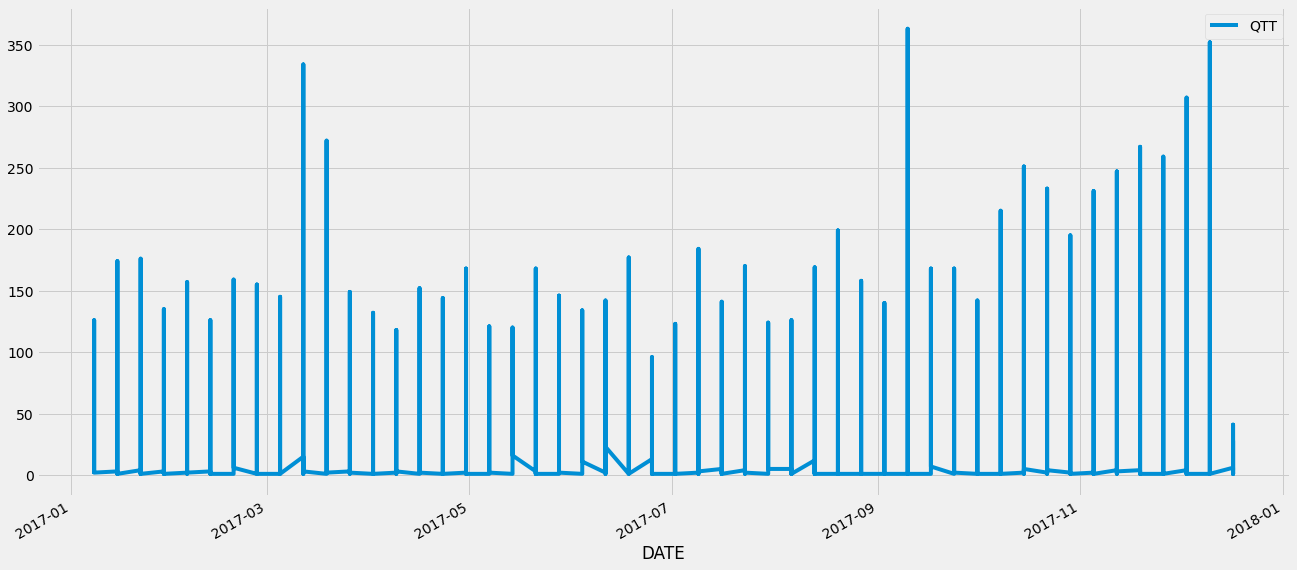

In [ ]:
sales.plot(x='DATE',y='QTT',figsize=(20,10))
plt.show()

In [ ]:
# Criação de novas Features baseadas em DATE

sales['Year'] = sales['DATE'].dt.year
sales['Month'] = sales['DATE'].dt.month
sales['Day'] = sales['DATE'].dt.day
sales.head()

,S100,S101,S102,S103,I100,I101,I102,I103,0,DATE,C100,C101,QTT,Year,Month,Day
0,0,1,17,10,0,2,1,1,2017-08-06,2017-08-06,12.0,76.0,1.0,2017,8,6
1,0,1,17,10,0,2,1,1,2017-08-06,2017-08-06,12.0,256.0,2.0,2017,8,6
2,0,1,17,10,0,2,1,1,2017-08-06,2017-08-06,14.0,256.0,1.0,2017,8,6
3,0,1,17,10,0,2,1,1,2017-08-20,2017-08-20,12.0,354.0,1.0,2017,8,20
4,0,1,17,10,0,2,1,1,2017-08-20,2017-08-20,13.0,354.0,1.0,2017,8,20


In [ ]:
sales = sales[['DATE','S100','S101','S102','S103','I100','I101','I102','I103','C100','C101','QTT' ]]

In [ ]:
# Criação de novas variáveis

QTT_mean = sales['QTT'].mean()
QTT_DEV = sales['QTT'].std()
QTT_max = sales['QTT'].max()
c = QTT_mean + QTT_DEV
d = QTT_mean +(QTT_max/(3*QTT_DEV))

In [ ]:
# Seleção de parte do dataset devido a análise de tendência das vendas

#df_remove = sales.loc[sales['Month'] <= 6] 
#sales = sales.drop(df_remove.index)

#df_remove2 = sales.loc[sales['Year'] <= 2019] 
#sales = sales.drop(df_remove2.index)

cut = c
df_remove3 = sales.loc[sales['QTT'] >= cut]
sales = sales.drop(df_remove3.index)

sales.describe()

,S100,S101,S102,S103,I100,I101,I102,I103,C100,C101,QTT
count,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582842.000000
mean,14.857378,0.964289,10.970793,7.358194,45.164665,1.703912,1.350075,1.868477,13.513131,231.229425,1.879225
std,8.905870,0.185569,6.155676,3.246261,27.773263,1.304741,0.621765,0.362604,2.258599,113.600667,1.260481
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.000000,1.000000,4.000000,5.000000,19.000000,0.000000,1.000000,2.000000,13.000000,128.000000,1.000000
50%,14.000000,1.000000,12.000000,9.000000,45.000000,2.000000,1.000000,2.000000,14.000000,282.000000,1.000000
75%,23.000000,1.000000,18.000000,10.000000,71.000000,3.000000,2.000000,2.000000,14.000000,340.000000,2.000000
max,30.000000,1.000000,19.000000,10.000000,95.000000,5.000000,2.000000,2.000000,20.000000,354.000000,6.000000


In [ ]:
sales = sales[['DATE','S100','S101','S102','S103','I100','I101','I102','I103','C100','C101','QTT' ]]

In [ ]:
sales = sales[['DATE','S100','S101','S102','S103','I100','I101','I102','I103','C100','C101','QTT' ]]
sales['DATE'] = pd.to_numeric(sales['DATE'])

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582843 entries, 0 to 620461
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DATE    582843 non-null  int64  
 1   S100    582843 non-null  int64  
 2   S101    582843 non-null  int64  
 3   S102    582843 non-null  int64  
 4   S103    582843 non-null  int64  
 5   I100    582843 non-null  int64  
 6   I101    582843 non-null  int64  
 7   I102    582843 non-null  int64  
 8   I103    582843 non-null  int64  
 9   C100    582843 non-null  float64
 10  C101    582843 non-null  float64
 11  QTT     582842 non-null  float64
dtypes: float64(3), int64(9)
memory usage: 57.8 MB


In [ ]:
sales_train, sales_test = train_test_split(sales, test_size=0.35, random_state=42)

In [ ]:
sales.describe()

,DATE,S100,S101,S102,S103,I100,I101,I102,I103,C100,C101,QTT
count,5.828430e+05,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582843.000000,582842.000000
mean,1.499244e+18,14.857378,0.964289,10.970793,7.358194,45.164665,1.703912,1.350075,1.868477,13.513131,231.229425,1.879225
std,8.482326e+15,8.905870,0.185569,6.155676,3.246261,27.773263,1.304741,0.621765,0.362604,2.258599,113.600667,1.260481
min,1.483834e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.492301e+18,7.000000,1.000000,4.000000,5.000000,19.000000,0.000000,1.000000,2.000000,13.000000,128.000000,1.000000
50%,1.499558e+18,14.000000,1.000000,12.000000,9.000000,45.000000,2.000000,1.000000,2.000000,14.000000,282.000000,1.000000
75%,1.506211e+18,23.000000,1.000000,18.000000,10.000000,71.000000,3.000000,2.000000,2.000000,14.000000,340.000000,2.000000
max,1.513469e+18,30.000000,1.000000,19.000000,10.000000,95.000000,5.000000,2.000000,2.000000,20.000000,354.000000,6.000000


# **Convertendo o dataframe em um PyTorch Forecasting**

In [ ]:
max_prediction_length = 1
max_encoder_length = 27

#end_date = (DATE+timedelta(days=4)).strftime("%Y-%m-%d")
#DATE = DATE+timedelta(days=3)
#sales_train['DATE'] = pd.to_datetime(sales_train["DATE"]) - pd.Timedelta(10, unit='D')
#training_cutoff = sales_train['DATE'].max() - max_prediction_length


#le = LabelEncoder()
#sales_train.ShelveLoc = le.fit_transform(sales_train.ShelveLoc)

training = TimeSeriesDataSet(
    sales_train,
    time_idx="DATE",
    target="QTT",
    group_ids=['S100','S101','S102','S103','I100','I101','I102','I103','C100','C101'],
    min_encoder_length=0,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=['DATE'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['DATE'],
    categorical_encoders={
        'S100':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'S101':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'S102':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'S103':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'I100':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'I101':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'I102':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'I103':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'C100':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'C101':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
    
)

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, sales_train, predict=True, stop_randomization=True)

# create dataloaders for model

batch_size = 128  # definido entre 32 a 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# configurando modelo e treino

pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # gradientes de recorte é um hiperparâmetro e importante para evitar divergência
    # do gradiente para redes neurais recorrentes
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # não é significativo para encontrar a taxa de aprendizado, mas de outra forma muito importante
    learning_rate=0.03,
    hidden_size=16,  # hiperparâmetro mais importante além da taxa de aprendizado
    # número de cabeças de atenção. Configure para até 4 para grandes conjuntos de dados
    attention_head_size=1,
    dropout=0.1,  # entre 0,1 e 0,3 são bons valores
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantis por padrão
    loss=pytorch_forecasting.metrics.RMSE(),
    # reduza a taxa de aprendizado se não houver melhora na perda de validação após x épocas
    reduce_on_plateau_patience=4,
)
print(f"Número de parâmetros no modelo: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Número de parâmetros no modelo: 18.1k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1080: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  "`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_ba05c2eb-9999-4f8e-b9f3-2bc2c1b509ff.ckpt


suggested learning rate: 4.5708818961487505e-07


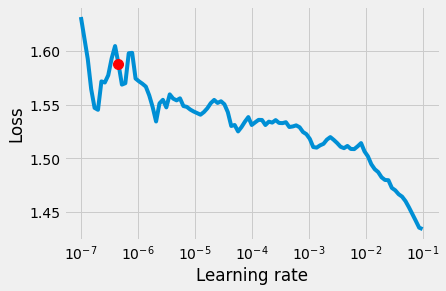

In [ ]:
# encontrar a taxa de aprendizado ideal
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configurar modelo e treino
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=5e-7,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,  
    loss=pytorch_forecasting.metrics.RMSE(),
    log_interval=10, 
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 18.1k


In [ ]:
# ajuste do modelo
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:736: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_select

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# carregar o melhor modelo de acordo com a perda de validação
# (dado que usamos a parada antecipada, esta não é necessariamente a última época)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcular o erro quadrático médio da raiz no conjunto de validação

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)

In [ ]:
criterion = nn.MSELoss()
torch.sqrt(criterion(actuals, val_predictions))

tensor(1.7804)

In [ ]:
# previsões são um dicionário do qual todo tipo de informação, incluindo quantis, pode ser extraída
pred, x = best_tft.predict(sales_test, return_x=True)
pred

In [ ]:
new_data = submission.ID.str.split("_", expand=True)
new_data.rename(columns={0: 'DATE', 1: 'S100', 2: 'I100', 3: 'C100', 4: 'C101'}, inplace=True)
new_data.head()

,DATE,S100,I100,C100,C101
0,2021-10-03,0,1,12,140
1,2021-10-03,0,1,12,164
2,2021-10-03,0,1,12,339
3,2021-10-03,0,1,13,128
4,2021-10-03,0,1,14,164


In [ ]:
new_data['DATE'] = pd.to_datetime(new_data['DATE'])
new_data['S100'] = pd.to_numeric(new_data['S100'])
new_data['I100'] = pd.to_numeric(new_data['I100'])
new_data['C100'] = pd.to_numeric(new_data['C100'])
new_data['C101'] = pd.to_numeric(new_data['C101'])

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69121 entries, 0 to 69120
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    69121 non-null  datetime64[ns]
 1   S100    69121 non-null  int64         
 2   I100    69121 non-null  int64         
 3   C100    69121 non-null  int64         
 4   C101    69121 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 2.6 MB


In [ ]:
#merge dos dados para submissão

teste = pd.merge(item, new_data, how='inner', on='I100')
new_data = pd.merge(store, teste, how='inner', on='S100')
new_data.head()

,S100,S101,S102,S103,I100,I101,I102,I103,DATE,C100,C101
0,0,1,17,10,1,2,1,1,2021-10-03,12,140
1,0,1,17,10,1,2,1,1,2021-10-03,12,164
2,0,1,17,10,1,2,1,1,2021-10-03,12,339
3,0,1,17,10,1,2,1,1,2021-10-03,13,128
4,0,1,17,10,1,2,1,1,2021-10-03,14,164


In [ ]:
new_data['Year'] = new_data['DATE'].dt.year
new_data['Month'] = new_data['DATE'].dt.month
new_data['Day'] = new_data['DATE'].dt.day
new_data['QTT'] = -1
new_data = new_data[['DATE','S100','S101','S102','S103','I100','I101','I102','I103','C100','C101','QTT']]
new_data['DATE'] = pd.to_numeric(new_data['DATE'])
new_data['QTT'] = pd.to_numeric(new_data['QTT'])
new_data.head()

,DATE,S100,S101,S102,S103,I100,I101,I102,I103,C100,C101,QTT
0,1633219200000000000,0,1,17,10,1,2,1,1,12,140,-1
1,1633219200000000000,0,1,17,10,1,2,1,1,12,164,-1
2,1633219200000000000,0,1,17,10,1,2,1,1,12,339,-1
3,1633219200000000000,0,1,17,10,1,2,1,1,13,128,-1
4,1633219200000000000,0,1,17,10,1,2,1,1,14,164,-1


In [ ]:
pred, x=best_tft.predict(new_data, return_x=True)
result = pd.DataFrame(pred).astype("float")

submission['QTT'] = result
submission['QTT'] = submission['QTT'].fillna(0)
submission

,ID,QTT
0,2021-10-03_0_1_12_140,3.033162
1,2021-10-03_0_1_12_164,3.033162
2,2021-10-03_0_1_12_339,3.033162
3,2021-10-03_0_1_13_128,3.033162
4,2021-10-03_0_1_14_164,3.033162
...,...,...
69116,2021-11-21_0_89_13_354,0.000000
69117,2021-11-21_0_91_14_354,0.000000
69118,2021-11-21_0_92_14_354,0.000000
69119,2021-11-21_0_94_13_354,0.000000


In [ ]:
#gera o arquivo csv
submission.to_csv('submission_andre_2.csv', encoding='utf-8', index=False)